In [118]:
from google.colab import files
uploaded_file = files.upload()

Saving mix_wood2.jpg to mix_wood2.jpg


In [139]:
uploaded_file_name = next(iter(uploaded_file))
print(uploaded_file_name)

mix_wood2.jpg


In [140]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread(uploaded_file_name)
image = cv2.blur(image,(3,3))

In [141]:
height, width = image.shape[:2]

#画像の端の4点の画素値が黒か判断
#4点とも黒判定の場合、背景は黒として処理
judge_num = 0
if image[0,0][0] < 80 and image[0,0][1] < 80 and image[0,0][2] < 80:
  judge_num = judge_num + 1
if image[0,width - 1][0] < 80 and image[0,width - 1][1] < 80 and image[0,width - 1][2] < 80:
  judge_num = judge_num + 1
if image[height - 1,0][0] < 80 and image[height - 1,0][1] < 80 and image[height - 1,0][2] < 80:
  judge_num = judge_num + 1
if image[height - 1,width - 1][0] < 80 and image[height - 1,width - 1][1] < 80 and image[height - 1,width - 1][2] < 80:
  judge_num = judge_num + 1

In [142]:
lower = np.array([0,0,0])
if judge_num == 4:
  upper = np.array([100,100,100])
  print('背景は黒')
else :
  upper =np.array([40,40,40])
  print('背景は木')
green = cv2.inRange(image,lower,upper)

背景は木


In [143]:
green = cv2.bitwise_not(green)

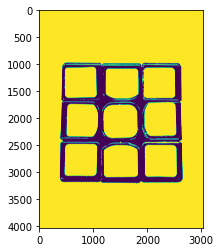

In [144]:
plt.imshow(green)

In [145]:
if judge_num ==4:
  kernelSize = max(1, int(0.02 * max(width, height))) * 2 + 1
  kernel = np.ones((kernelSize, kernelSize), dtype=np.int)
  green = cv2.erode(green, kernel) # 収縮
  green = cv2.dilate(green, kernel) # 膨張

  kernelSize = max(1, int(0.03 * max(width, height))) * 2 + 1
  kernel = np.ones((kernelSize, kernelSize), dtype=np.int)
  green = cv2.dilate(green, kernel) # 膨張
  green = cv2.erode(green, kernel) # 収縮
else:
  green = cv2.bitwise_not(green)
  #kernelSize = max(1, int(0.002 * max(width, height))) * 2 + 1
  #kernel = np.ones((kernelSize, kernelSize), dtype=np.int)
  #green = cv2.erode(green, kernel) # 収縮
  #green = cv2.dilate(green, kernel) # 膨張

  kernelSize = max(1, int(0.075 * max(width, height))) * 2 + 1
  kernel = np.ones((kernelSize, kernelSize), dtype=np.int)
  green = cv2.dilate(green, kernel) # 膨張

  kernelSize = max(1, int(0.085 * max(width, height))) * 2 + 1
  kernel = np.ones((kernelSize, kernelSize), dtype=np.int)
  green = cv2.erode(green, kernel) # 収縮

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

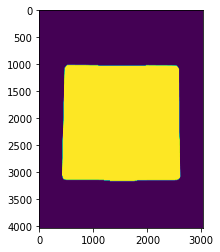

In [146]:
plt.imshow(green)

In [147]:
contours, hierarchy = cv2.findContours(green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [148]:
for i, c in enumerate(contours):
    hull = cv2.convexHull(c) # 凸包

In [149]:
epsilon = 0.04 * cv2.arcLength(hull, True)
approx = cv2.approxPolyDP(hull, epsilon, True)
print(approx)

[[[2575 3128]]

 [[ 440 3114]]

 [[ 507 1025]]

 [[2550 1037]]]


In [150]:
if approx[0][0][0] + approx[0][0][1] < approx[1][0][0] + approx[1][0][1]:
  approx = np.roll(approx,6)
print(approx)

[[[2575 3128]]

 [[ 440 3114]]

 [[ 507 1025]]

 [[2550 1037]]]


In [151]:
margin = 13 # マージンの幅
cell_size = 42 # 1マスのサイズ
size = cell_size * 8 + margin * 2 # 変換後の辺の長さ
outer = (254, 0, 0) # マージン部分の色

In [152]:
# 移動元の4頂点
src = np.array([approx[2], approx[3], approx[0], approx[1]], dtype=np.float32)
# 移動先の4頂点
dst = np.array([
    [margin, margin],
    [size - 1 - margin, margin],
    [size - 1 - margin, size - 1 - margin],
    [margin, size - 1 - margin]
], dtype=np.float32)

In [153]:
# 変換行列
trans = cv2.getPerspectiveTransform(src, dst)
# 射影変換
board = cv2.warpPerspective(image, trans, (int(size), int(size)), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=outer)

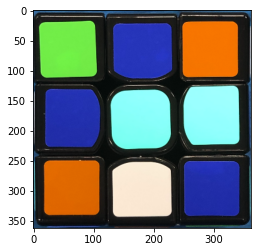

In [154]:
plt.imshow(board)

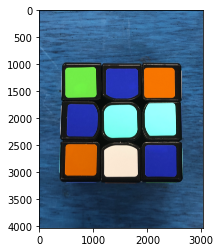

In [155]:
plt.imshow(image)

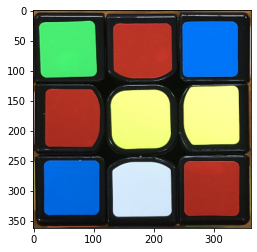

In [156]:
rgbImage = cv2.cvtColor(board, cv2.COLOR_BGR2RGB)
plt.imshow(rgbImage)

In [157]:
color = np.zeros(9,dtype=str)
color_num = np.zeros(9)
mix_list = []

for i in range(-1,2):
  for j in range(-1,2):
    R = rgbImage[size//2+i*(size//3),size//2+j*(size//3),0]
    G = rgbImage[size//2+i*(size//3),size//2+j*(size//3),1]
    B = rgbImage[size//2+i*(size//3),size//2+j*(size//3), 2]

    if R >150 and G >150 and B >150 and (abs(int(R) - int(B)) < 40 or abs(int(G) - int(B)) < 40):
      color[4+3*i+j] = 'w'
      print('white')
    elif R >150 and G >150 and abs(int(R) - int(G) < 60):
      color[4+3*i+j] = 'y'
      print('yellow')
    elif R >190 and G <70 and B <100:
      color[4+3*i+j] = 'r'
      color_num[4+3*i+j] = int(R) + int(G)
      mix_list.append(int(R) + int(G))
      print('probably red')
    elif R >150 and G >70 and B <150:
      color[4+3*i+j] = 'o'
      color_num[4+3*i+j] = int(R) + int(G)
      mix_list.append(int(R) + int(G))
      print('probably orange')
    elif int(R) - int(G) > 0 and int(R) - int(B) > 0:
      color_num[4+3*i+j] = int(R) + int(G)
      color[4+3*i+j] = 'r'
      mix_list.append(int(R) + int(G))
      print('probably red')
    elif int(B) - int(G) > 0 and int(B) - int(R) > 0:
      color[4+3*i+j] = 'b'
      print('blue')
    elif int(G) - int(R) > 0 and int(G) - int(B) > 0:
      color[4+3*i+j] = 'g'
      print('green')
    else:
      color[4+3*i+j] = 'n'
      print('fail')
    
    print(rgbImage[size//2+i*(size//3),size//2+j*(size//3)])

mix_list = sorted(mix_list)
if len(mix_list) > 1 and max(mix_list) - min(mix_list) > 100:
  for i in range(9):
    if color_num[i] != 0 and max(mix_list) - color_num[i] < 40:
      color[i] = 'o'
    elif color_num[i] != 0:
      color[i] = 'r'
 

green
[ 72 238 114]
probably red
[184  51  36]
blue
[  0 116 246]
probably red
[173  45  32]
yellow
[250 255 137]
yellow
[254 255 147]
blue
[  0 105 223]
white
[211 232 251]
probably red
[171  47  35]


['g' 'r' 'b' 'r' 'y' 'y' 'b' 'w' 'r']


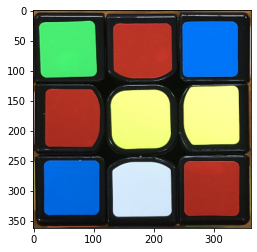

In [158]:
print(color)
plt.imshow(rgbImage)